In [1]:
import numpy as np
from scipy.fftpack import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
import scipy.sparse as sps
#from scipy.misc import imread
#N.B. This can be deprecated depending on the python version. Use cv2 in this case

import cv2   # if imread does not work for you.

# N.B. You can install cv2 by calling 'conda install opencv' or 'pip install opencv' in the terminal
# If you have incompatibilities with hdf5, you can uninstall it by command line 'conda remove hdf5' or 
# 'pip remove hdf5' and then install opencv

from scipy.sparse.linalg import LinearOperator, svds
from pywt import wavedec2, waverec2, coeffs_to_array, array_to_coeffs
from collections import namedtuple
from math import sqrt

import time
import pylab as pl
from IPython import display


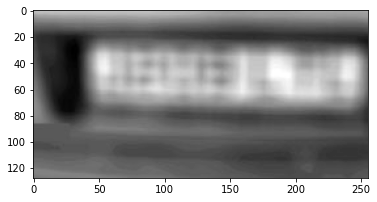

C:\Users\Elia\AppData\Local\Temp/ipykernel_15884/2015356367.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind1 = np.int(imsize1/2-(K1+1)/2+1)
C:\Users\Elia\AppData\Local\Temp/ipykernel_15884/2015356367.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

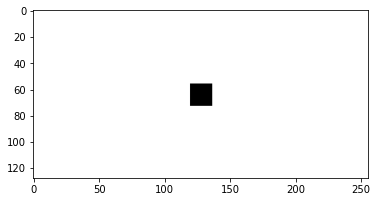

In [2]:
# Mappings between n dimensional complex space and 2n dimensional real space
real2comp = lambda x: x[0:x.shape[0]//2] + 1j*x[x.shape[0]//2:]
comp2real = lambda x: np.append(x.real, x.imag)

# Load Data
#x = imread('blurredplate.jpg',flatten=True,mode='F')
x = cv2.imread('blurredplate.jpg' , cv2.IMREAD_GRAYSCALE) #If imread does not work for you
x = x[60:188,40:296]
x = x/np.linalg.norm(x,ord=np.inf)

imsize1 = x.shape[0]
imsize2 = x.shape[1]
imsize = imsize1*imsize2

# Shows the blurred image!
plt.imshow(x, cmap='gray')
plt.show()

# Reshaping operators matrix to vector and vector to matrix
mat = lambda x: np.reshape(x,[imsize1,imsize2])
vec = lambda x: x.flatten()

# Set the measurement vector b
b = comp2real(vec(fft2(fftshift(x))))

# Roughly estimate the support of the blur kernel
K1 = 17
K2 = 17
Indw = np.zeros([imsize1,imsize2])
ind1 = np.int(imsize1/2-(K1+1)/2+1)
ind2 = np.int(imsize1/2+(K1+1)/2)
ind3 = np.int(imsize2/2-(K2+1)/2+1)
ind4 = np.int(imsize2/2+(K2+1)/2)
Indw[ind1:ind2,ind3:ind4] = 1
#above, for implementational simplicity we assume K1 and K2 odd, even  
#if they are even 1 pixel probably won't cause much trouble
plt.imshow(-Indw, cmap='gray') # Shows the estimated support of blur kernel!
plt.show()
Indw = vec(Indw);
kernelsize = np.count_nonzero(Indw)
Indi = np.nonzero(Indw > 0)[0]
Indv = Indw[Indi]

# Define operators Bop and Cop
Bmat = sps.csr_matrix((Indv,(Indi,range(0,kernelsize))),shape=(imsize,kernelsize))
Bop = lambda x: mat(Bmat.dot(x))
BTop = lambda x: Bmat.T.dot(vec(x))

# Compute and display wavelet coefficients of the original and blurred image
l = coeffs_to_array(wavedec2(x, 'db1', level=4))[1]
Cop = lambda x: waverec2(array_to_coeffs(mat(x),l,output_format='wavedec2'),'db1')
CTop = lambda x: coeffs_to_array(wavedec2(x, 'db1', level=4))[0]

# Define operators
Aoper = lambda m,n,h: comp2real(1.0/sqrt(imsize)*n*vec(fft2(Cop(m))*fft2(Bop(h))))
AToper = {"matvec": lambda y,w: CTop(np.real(fft2(mat(np.conj(real2comp(y))*vec(fft2(Bop(w)))))))/sqrt(y.shape[0]/2.0),
         "rmatvec": lambda y,w: BTop(np.real(ifft2(mat(real2comp(y)*vec(ifft2(Cop(w)))))))*(y.shape[0]/2.0)**1.5}


In [3]:
def plot_func(mEst, C, x):
    
    xEst = -C(mEst);
    xEst = xEst - min(xEst.flatten())
    xEst = xEst/max(xEst.flatten())
    plt.imshow(xEst, cmap='gray')
    plt.show()


In [4]:
def frank_wolfe(Aoper, AToper, b, n1, n2, kappa, maxit, plotFunc):
# PURPOSE: We will solve the following problem formulation with
# Frank-Wolfe's method.                                    
#                   min_x  0.5*norm(A(x) - b)^2        
#                   s.t.:  norm_nuc(x) <= kappa,     
#
# Laboratory for Information and Inference Systems (LIONS)
# Ecole Polytechnique Federale de Lausanne (EPFL) - SWITZERLAND
# Last modification: November 26, 2019
    
    # Print the caption
    
    #Initialize 
    AX_t = 0.0   # zeros
    X = 0.0      # zeros
    
    # keep track of objective value
    fx = np.array([])
        
    # The main loop    
    for iteration in range(0, maxit+1):
        
        # Print the objective values ...
        fx = np.append(fx, 0.5*np.linalg.norm(AX_t - b,2)**2)
        print('{:03d} | {:.4e}'.format(iteration, fx[-1]))

        # Form the residual and fix the operator to be used in svds.
        res_cur = AX_t - b
        ATop1 = lambda w: AToper["matvec"](res_cur,w)
        ATop2 = lambda w: AToper["rmatvec"](res_cur,w)
        svdsArg = LinearOperator((n2,n1), matvec=ATop1, rmatvec=ATop2)
        topLe_vec, singVal, topRe_vec = svds(svdsArg, k=1, tol=1e-4, which='LM')
        
        # Apply A to the rank 1 update
        AXsharp_t = Aoper(topLe_vec, -kappa, topRe_vec.T)
        
        # Step size
        weight = 2/(iteration + 2)
        
        # Update A*X
        AX_t = (1.0-weight)*AX_t + weight*(AXsharp_t)
        
        # Update X
        X = (1.0 - weight) * X + weight * (-kappa) * np.outer(topLe_vec, topRe_vec)

        
        # Show the reconstruction (at every 10 iteration) 
        if (float(iteration/10) == float(iteration)/10):
            U,S,V = np.linalg.svd(X,full_matrices=0,compute_uv=1)
            plotFunc(U[:,0])

    return X
    

000 | 4.1489e+03


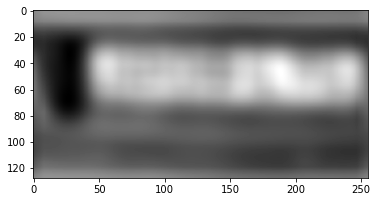

001 | 1.3983e+08


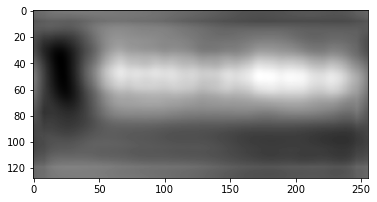

002 | 1.6647e+07


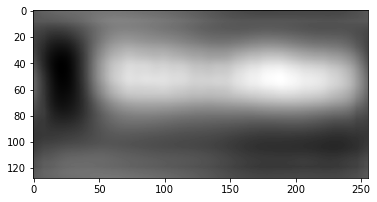

003 | 1.5392e+07


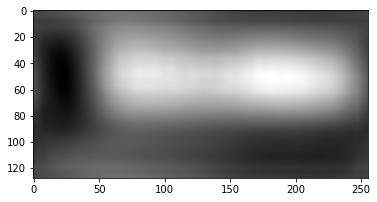

004 | 6.1033e+06


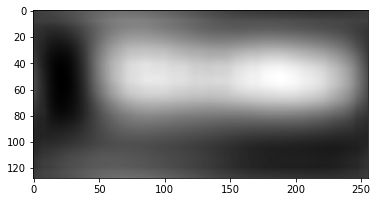

005 | 5.4488e+06


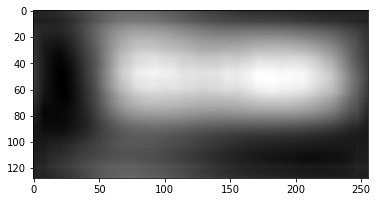

006 | 3.1732e+06


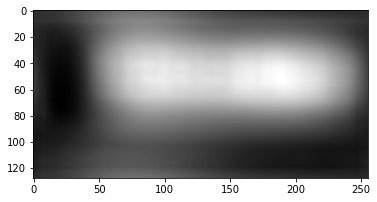

007 | 2.7282e+06


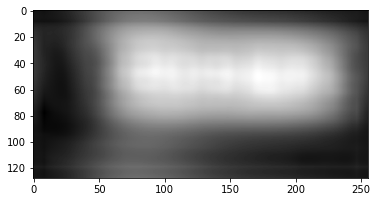

008 | 1.9560e+06


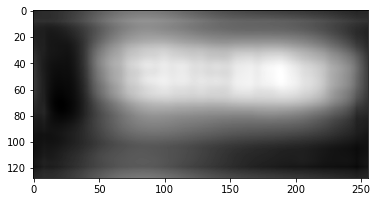

009 | 1.6183e+06


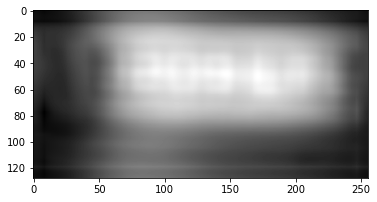

010 | 1.3339e+06


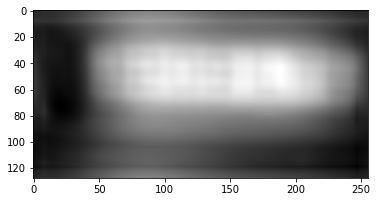

011 | 1.0618e+06


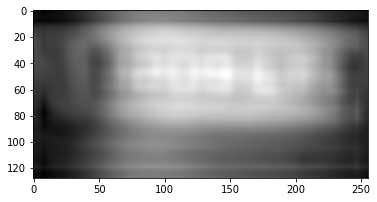

012 | 9.7272e+05


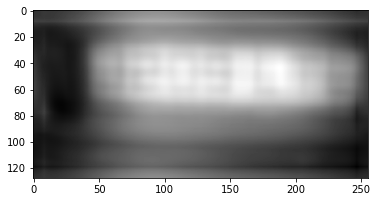

013 | 7.4485e+05


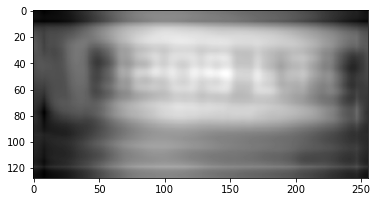

014 | 7.4397e+05


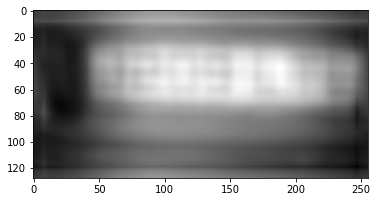

015 | 5.4800e+05


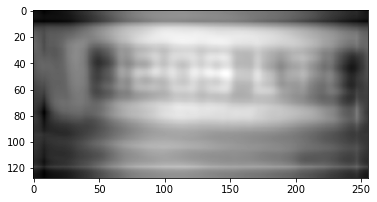

016 | 5.8969e+05


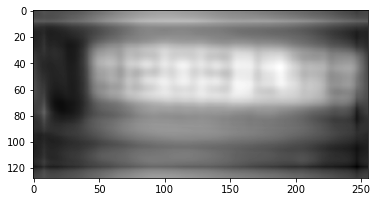

017 | 4.1780e+05


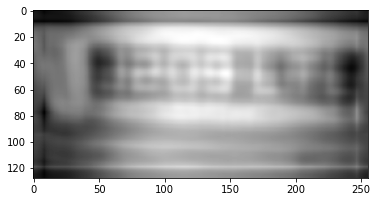

018 | 4.8052e+05


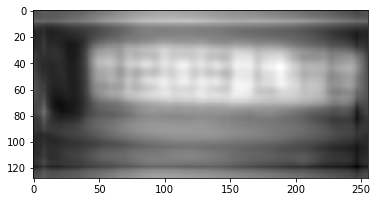

019 | 3.2746e+05


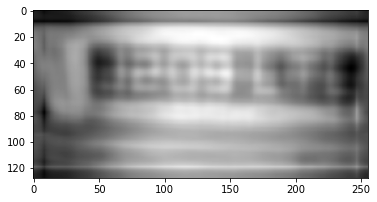

020 | 4.0031e+05


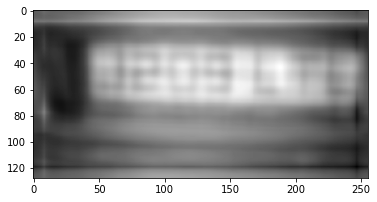

021 | 2.6238e+05


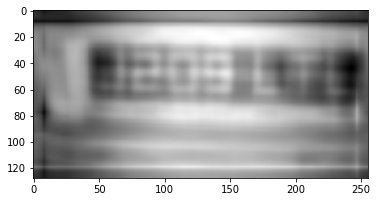

022 | 3.3957e+05


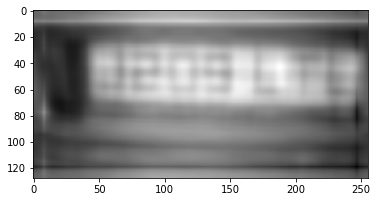

023 | 2.1405e+05


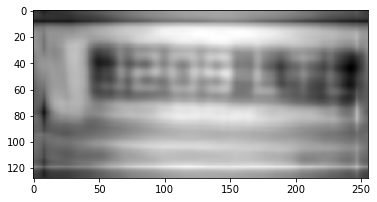

024 | 2.9240e+05


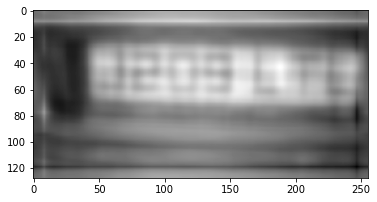

025 | 1.7725e+05


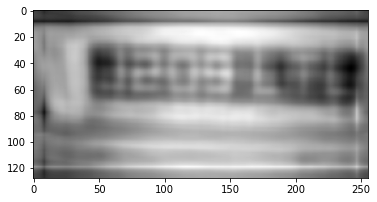

026 | 2.5500e+05


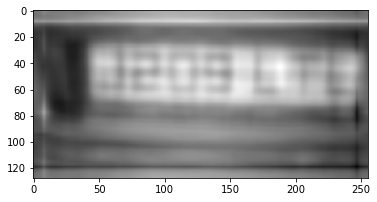

027 | 1.4864e+05


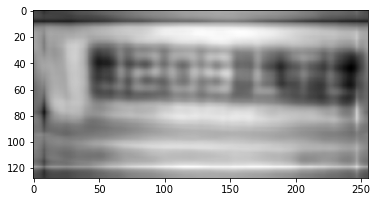

028 | 2.2482e+05


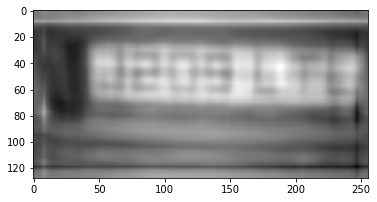

029 | 1.2599e+05


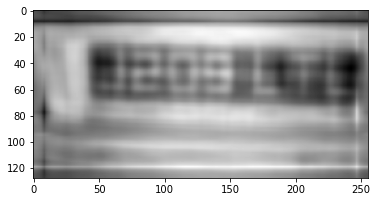

030 | 2.0007e+05


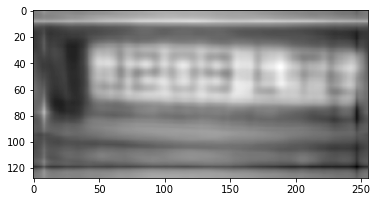

031 | 1.0779e+05


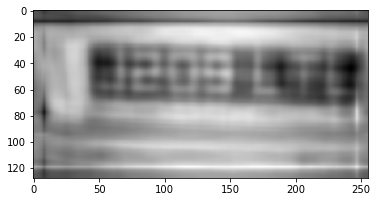

032 | 1.7952e+05


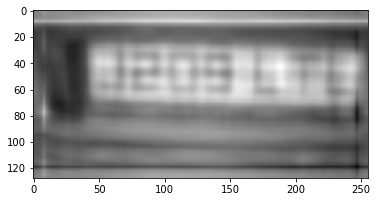

033 | 9.2969e+04


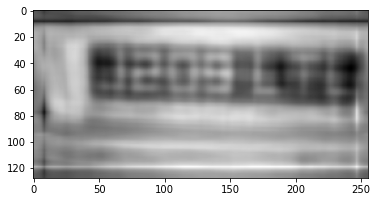

034 | 1.6225e+05


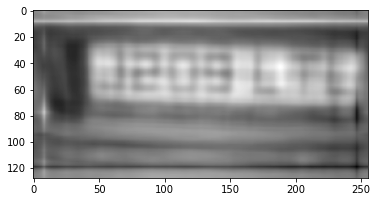

035 | 8.0755e+04


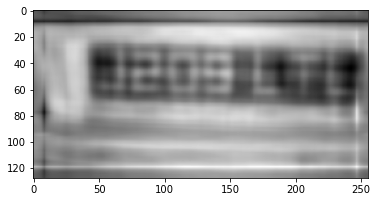

036 | 1.4758e+05


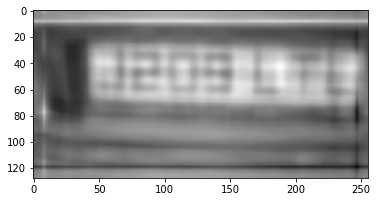

037 | 7.0588e+04


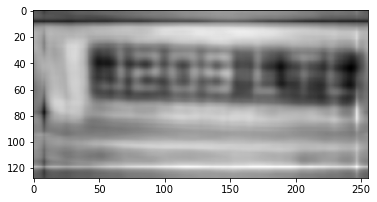

038 | 1.3500e+05


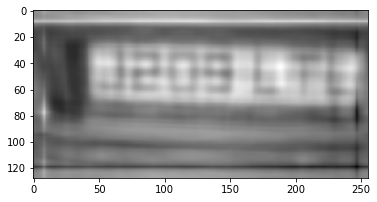

039 | 6.2045e+04


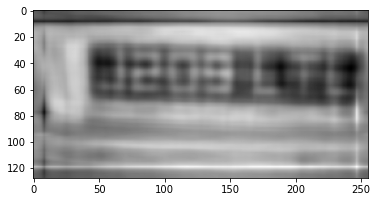

040 | 1.2414e+05


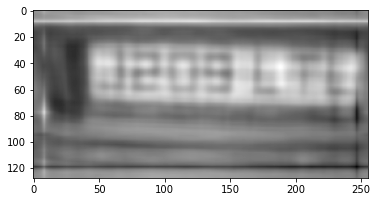

041 | 5.4808e+04


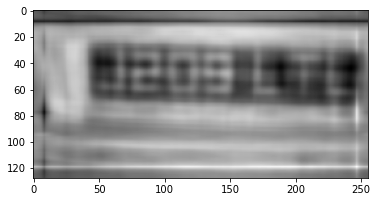

042 | 1.1468e+05


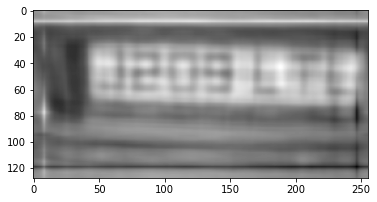

043 | 4.8633e+04


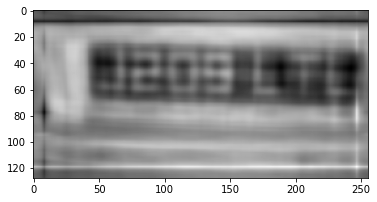

044 | 1.0639e+05


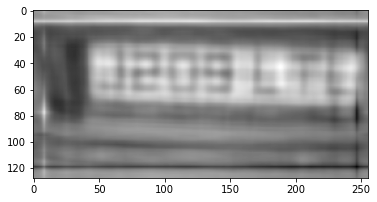

045 | 4.3327e+04


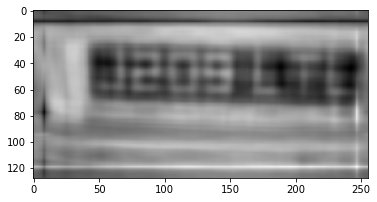

046 | 9.9072e+04


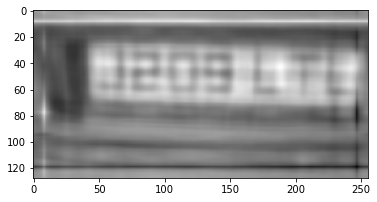

047 | 3.8742e+04


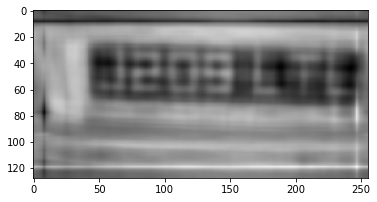

048 | 9.2584e+04


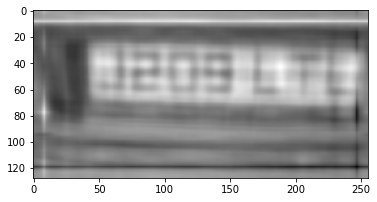

049 | 3.4756e+04


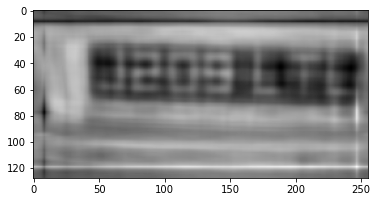

050 | 8.6800e+04


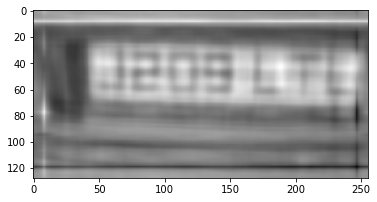

In [6]:
# Run Frank-Wolfe's method
MaxIters = 50
kappa = 1000
plotF = lambda m: plot_func(m,Cop,x)
xFW = frank_wolfe(Aoper, AToper, b, kernelsize, imsize, kappa, MaxIters, plotF)

In [ ]:
# NOTE: This experiment is based on the theory and the codes publised in
#'Blind Deconvolution using Convex Programming' by A.Ahmed, B.Recht and J.Romberg.